In [85]:
library(matlib)
library(deSolve)
library(ggplot2)
dev.new(width=8, height=4.5)

In [2]:
install.packages('tidyverse')

also installing the dependencies 'bit', 'cachem', 'farver', 'fs', 'rappdirs', 'bit64', 'progress', 'processx', 'xfun', 'lifecycle', 'memoise', 'blob', 'tidyselect', 'vctrs', 'glue', 'isoband', 'scales', 'gargle', 'ids', 'cpp11', 'timechange', 'systemfonts', 'textshaping', 'vroom', 'tzdb', 'callr', 'knitr', 'stringi', 'broom', 'conflicted', 'cli', 'dbplyr', 'dplyr', 'dtplyr', 'forcats', 'ggplot2', 'googledrive', 'googlesheets4', 'haven', 'hms', 'httr', 'jsonlite', 'lubridate', 'magrittr', 'modelr', 'pillar', 'purrr', 'ragg', 'readr', 'readxl', 'reprex', 'rlang', 'rstudioapi', 'rvest', 'stringr', 'tibble', 'tidyr', 'xml2'




  There are binary versions available but the source versions are later:
              binary source needs_compilation
bit            4.0.4  4.0.5              TRUE
cachem         1.0.4  1.0.7              TRUE
farver         2.1.0  2.1.1              TRUE
fs             1.5.0  1.6.1              TRUE
processx       3.5.2  3.8.1              TRUE
xfun            0.22   0.39              TRUE
lifecycle      1.0.0  1.0.3             FALSE
memoise        2.0.0  2.0.1             FALSE
blob           1.2.1  1.2.4             FALSE
tidyselect     1.1.1  1.2.0             FALSE
vctrs          0.3.8  0.6.2              TRUE
glue           1.4.2  1.6.2              TRUE
isoband        0.2.4  0.2.7              TRUE
scales         1.1.1  1.2.1             FALSE
gargle         1.1.0  1.4.0             FALSE
cpp11          0.2.7  0.4.3             FALSE
timechange     0.0.2  0.2.0              TRUE
systemfonts    1.0.2  1.0.4              TRUE
textshaping    0.3.4  0.3.6              TRUE
vroom 

Warning message:
"cannot remove prior installation of package 'jsonlite'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying D:\Anaconda\envs\myenv\lib\R\library\00LOCK\jsonlite\libs\x64\jsonlite.dll to D:\Anaconda\envs\myenv\lib\R\library\jsonlite\libs\x64\jsonlite.dll: Permission denied"Warning message:
"restored 'jsonlite'"

package 'lubridate' successfully unpacked and MD5 sums checked
package 'magrittr' successfully unpacked and MD5 sums checked
package 'purrr' successfully unpacked and MD5 sums checked
package 'ragg' successfully unpacked and MD5 sums checked
package 'readr' successfully unpacked and MD5 sums checked
package 'readxl' successfully unpacked and MD5 sums checked
package 'rlang' successfully unpacked and MD5 sums checked
package 'tibble' successfully unpacked and MD5 sums checked
package 'tidyr' successfully unpacked and MD5 sums checked
package 'xml2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\joely\AppData\Local\Temp\Rtmp48znSy\downloaded_packages


installing the source packages 'lifecycle', 'memoise', 'blob', 'tidyselect', 'scales', 'gargle', 'cpp11', 'callr', 'knitr', 'broom', 'conflicted', 'dbplyr', 'dtplyr', 'forcats', 'ggplot2', 'googledrive', 'googlesheets4', 'hms', 'httr', 'modelr', 'pillar', 'reprex', 'rstudioapi', 'rvest', 'stringr', 'tidyverse'

Warning message in install.packages("tidyverse"):
"installation of package 'lifecycle' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'callr' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'knitr' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'tidyselect' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'scales' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'gargle' had non-zero exit status"Warning message in install.p

## SIR model
We first decide what model to use. Using X,Y,Z to represent total numbers instead of proportions: 

$\frac{dX}{dt} = -\frac{\beta{X}{Y}}{N}$

$\frac{dY}{dt} = \frac{\beta{X}{Y}}{N} - \gamma{Y}$

$\frac{dZ}{dt} = \gamma{Y}$

In [86]:
model <- function(beta, gamma, initial_conditions, times){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- X+Y+Z
            dX <- -beta * X * Y/N
            dY <- beta * X*Y/N - gamma * Y
            dZ <-  gamma * Y
            return(list(c(dX, dY, dZ)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = c(0,times),
        func = equations,
        parms = c(beta=beta, gamma=gamma) 
    )
    # Always have to pass t=0 state to ode solver as it gets it's IC from t=0.
    return(as.data.frame(out)[-1,])
}

## Dataset

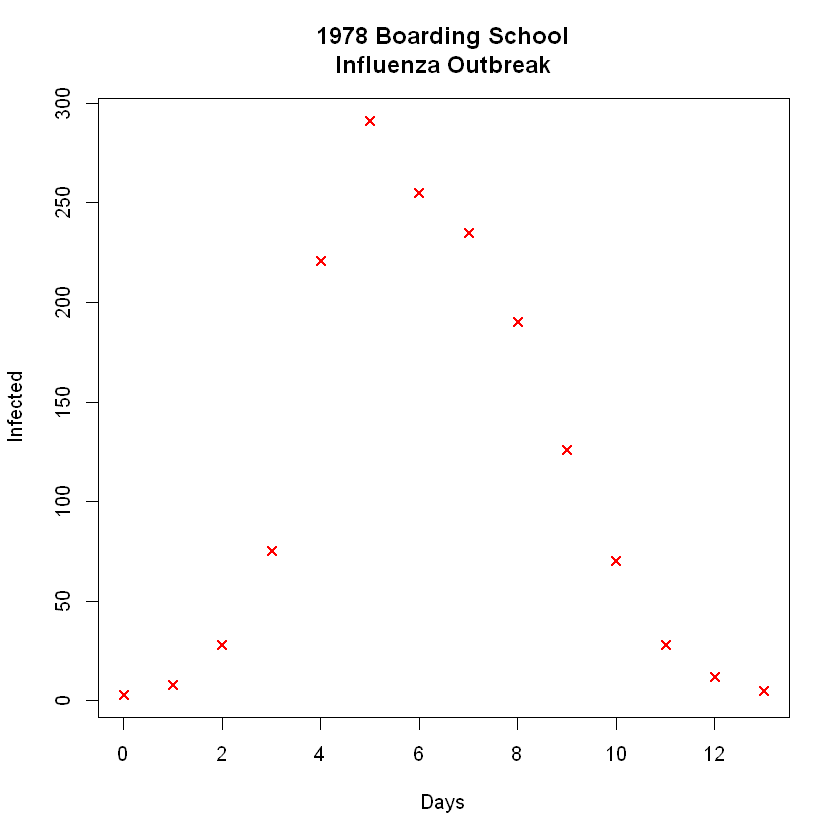

In [108]:
df <- data.frame(read.csv('Datasets/Chapter4.csv', header=TRUE))
N = 763
df$days <- df$days - 1
initial_conditions <- c(X=(N-df$cases[1]), Y=df$cases[1], Z=0)
plot(df$days, df$cases, xlab='Days', ylab='Infected', main='1978 Boarding School
Influenza Outbreak', col='red', pch=4, lwd=1.6)

## Generic model comparison code
Function to compare model results to data quicker.

In [88]:
compare_model <- function(predicted, title, times){
    plot(df$days, df$cases, xlab='Days', ylab='Prevalence', col='red', lwd=1.6, pch=4)
    legend(9, 300, legend=c("Predicted", "Actual"),
           col=c("red", "blue"), lty=1:5, y.intersp=2)
    
    lines(loess(predicted~times), col='blue', lty=5)
    title(title)
}

## 1.1 Least Squares 
First we do basic least squares as a base benchmark 

In [89]:
sse <- function(params) {
  I0 <- df$cases[1]
  times <- df$days
  predictions <- model(beta = params[1], gamma = params[2], initial_conditions,times = df$days)
  sum((predictions$Y[-1] - df$cases[-1])^2)
}

In [90]:
starting_param_val <- c(1, 1)
ss_optim <- optim(starting_param_val, sse)
parameters_ss <- c(beta=ss_optim$par[1], gamma=ss_optim$par[2])
ss_optim$value

[1] 3897.9

## 1.2 Least Squares Analysis

In [91]:
times <- seq(1,20,0.1)
ss_model <-model(gamma=as.double(parameters_ss['gamma']),
                       beta=as.double(parameters_ss['beta']),
                       times = times,
                       initial_conditions=initial_conditions)
parameters_ss

beta     gamma 
1.6978154 0.4512395

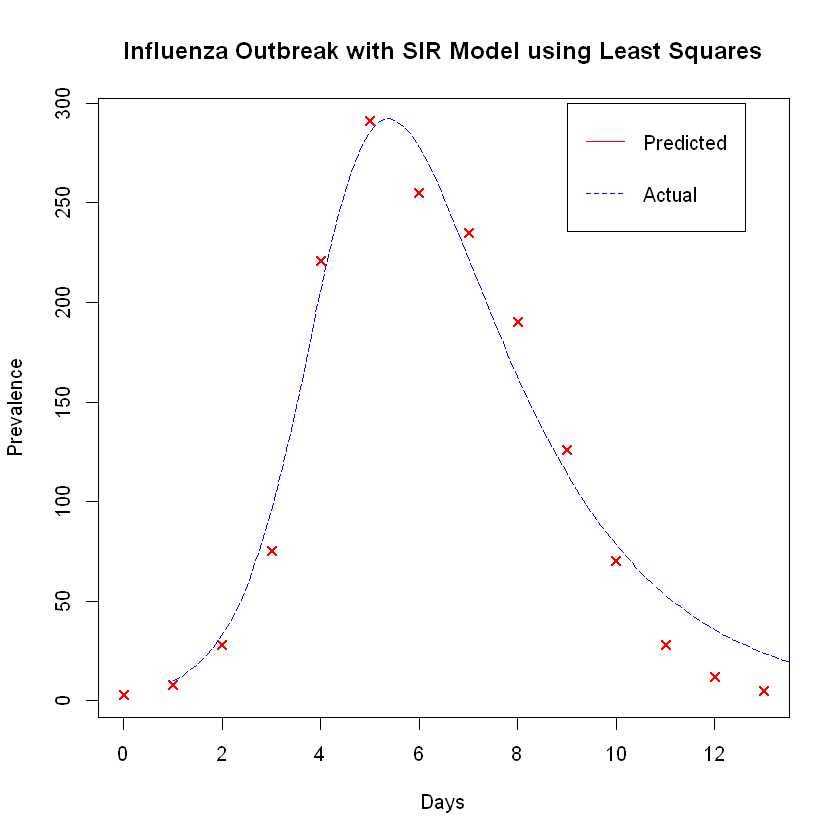

In [92]:
compare_model(ss_model$Y, "Influenza Outbreak with SIR Model using Least Squares", times)

## Normal likelihood

In [93]:
normalLL <- function(beta, gamma, sigma){
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_conditions=initial_conditions)$Y[-1]
    -sum(dnorm(x=df$cases[-1],mean=model_data, sd=sigma, log=TRUE))
}

beta      gamma      sigma     logLik        AIC 
  1.697753   0.451228  17.315773  55.517284 117.034568

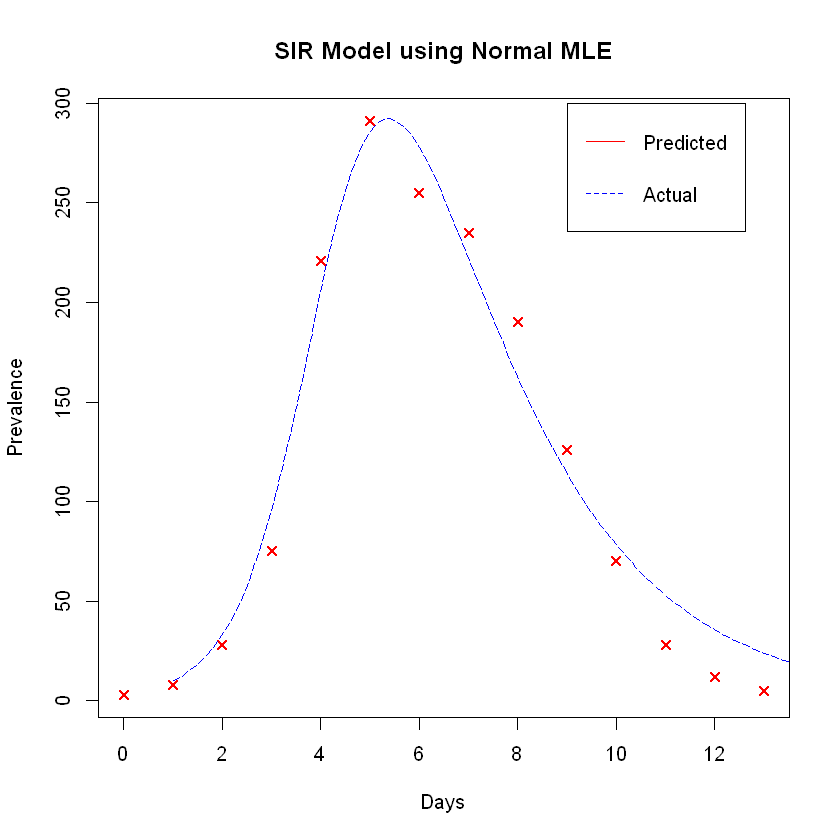

In [94]:
starting_param_val <- c(ss_optim$par, 10)
nMLL <- function(params) normalLL(params[1], params[2], params[3])

normal_optim <- optim(starting_param_val, nMLL, lower=c(0,0,1),
                 upper=c(10,10,1000),
                 method="L-BFGS-B",hessian=TRUE)
normal_params<-c(beta=(normal_optim$par[1]), gamma=(normal_optim$par[2]), sigma=(normal_optim$par[3]), logLik=normal_optim$value, AIC=6+2*normal_optim$value)
normal_params

normal_model <-c(as.double(model(gamma=as.double(normal_params['gamma']),
                       beta=as.double(normal_params['beta']),
                       times = times,
                       initial_conditions=initial_conditions)$Y))
compare_model(normal_model, "SIR Model using Normal MLE", times)

## Poisson likelihood

In [95]:
poissonLL <- function(beta, gamma){
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_conditions=initial_conditions)$Y[-1]
    -sum(dpois(x = df$cases[-1], lambda = model_data, log = TRUE))
}

pLL <- function(params) poissonLL(params[1], params[2])

beta      gamma     logLik        AIC 
 1.7220825  0.4797973 71.7689849 75.7689849

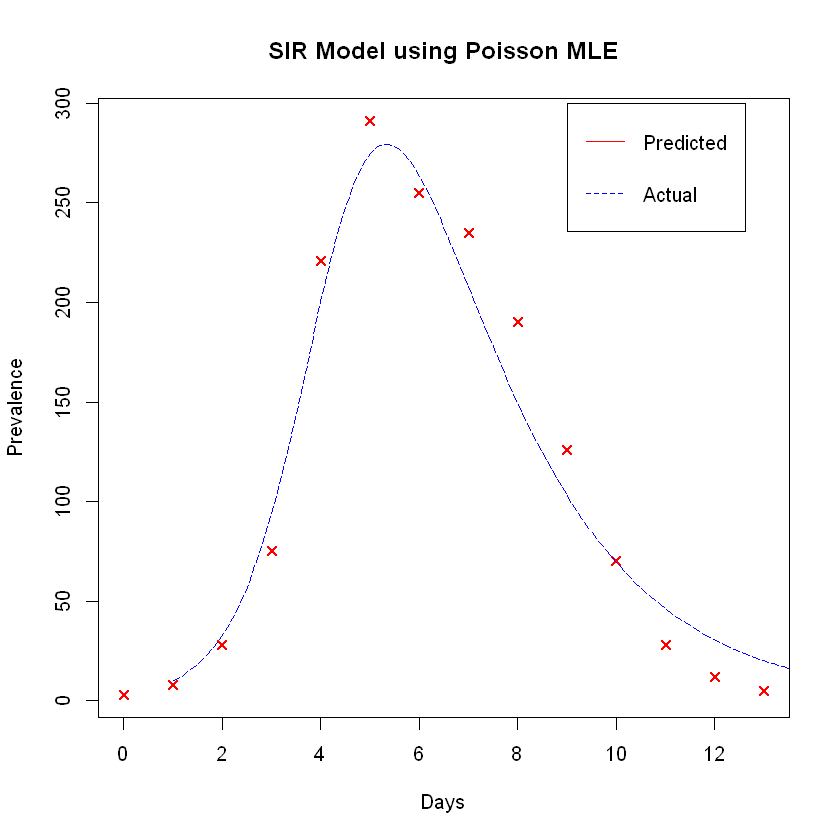

In [96]:
poisson_optim <- optim(ss_optim$par, pLL, lower=c(0,0),
                 upper=c(10,1),
                 method="L-BFGS-B",hessian=TRUE)
poisson_params<-c(beta=(poisson_optim$par[1]), gamma=(poisson_optim$par[2]), logLik=poisson_optim$value, AIC=4 + poisson_optim$value)
poisson_params

poisson_model <-c(as.double(model(gamma=as.double(poisson_params['gamma']),
                       beta=as.double(poisson_params['beta']),
                       times = times,
                       initial_conditions=initial_conditions)$Y))
compare_model(poisson_model, "SIR Model using Poisson MLE", times)

## Negative Binomial Likelihood

beta      gamma dispersion     logLik        AIC 
 1.7602671  0.5363874 13.0785212 58.4701023 62.4701023

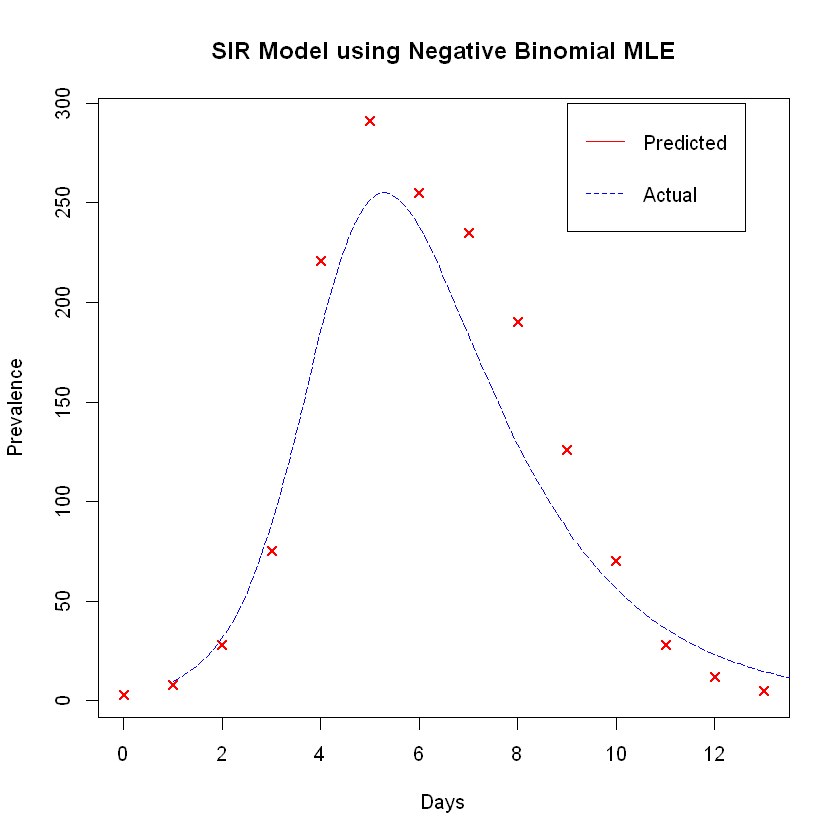

In [97]:
negativeBinLL <- function(beta, gamma, dispersion){
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_conditions=initial_conditions)$Y[-1]
    -sum(dnbinom(x=df$cases[-1], s=dispersion, mu=model_data, log=TRUE))
}

nLL <- function(params) negativeBinLL(params[1], params[2], params[3])

negativeBin_optim <- optim(c(ss_optim$par,10), nLL, lower=c(0,0,-Inf),
                 upper=c(10,1, Inf),
                 method="L-BFGS-B", hessian=TRUE)
negativeBin_params<-c(beta=(negativeBin_optim$par[1]), gamma=(negativeBin_optim$par[2]), dispersion=(negativeBin_optim$par[3]),logLik=negativeBin_optim$value, AIC=4 + negativeBin_optim$value)
negativeBin_params

negativeBin_model <-c(as.double(model(gamma=as.double(negativeBin_params['gamma']),
                       beta=as.double(negativeBin_params['beta']),
                       times = times,
                       initial_conditions=initial_conditions)$Y))
compare_model(negativeBin_model, "SIR Model using Negative Binomial MLE", times)

## Plotting Uncertainties
Note that the negative sign is not here as it cancels with the negative log-likelihood

In [98]:
negativeBin_err <- sqrt(diag(inv(negativeBin_optim$hessian)));
poisson_err <- sqrt(diag(inv(poisson_optim$hessian)));
normal_err <- sqrt(diag(inv(normal_optim$hessian)));

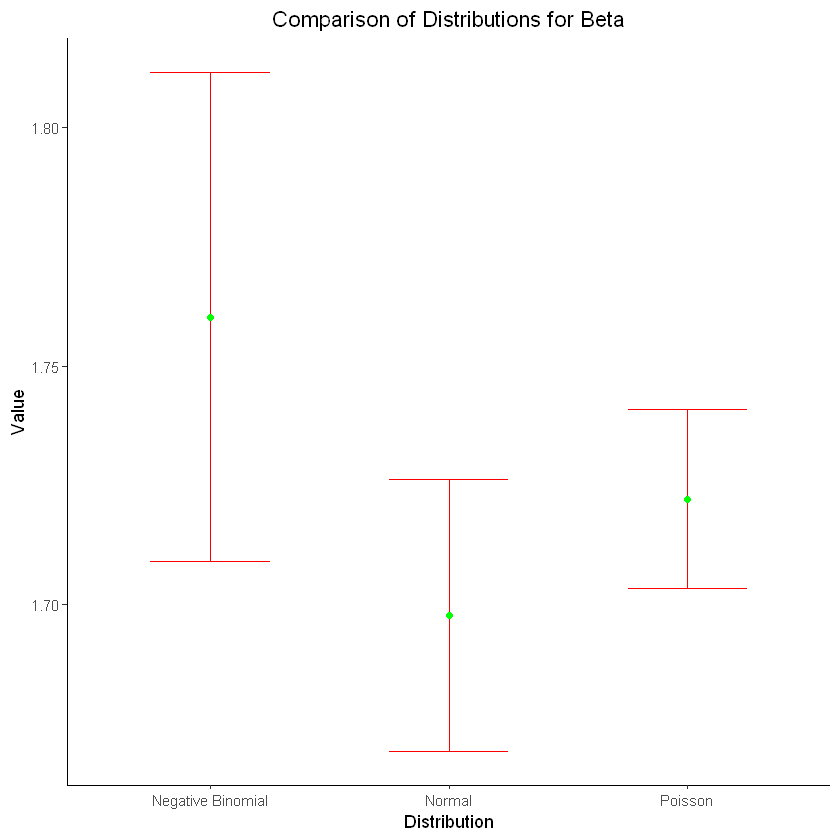

In [99]:
beta_estimates <- data.frame(distribution = c('Normal', 'Poisson', 'Negative Binomial'),
                             value=c(normal_params['beta'],poisson_params['beta'], negativeBin_params['beta']),
                             uncertainty = c(normal_err[1], poisson_err[1], negativeBin_err[1]));

ggplot(beta_estimates, aes(x = distribution, y=value)) +
  geom_errorbar(aes(ymin=value-uncertainty, ymax=value+uncertainty), width=.5,
                 position=position_dodge(.9), color='red')+geom_point(color='green')+theme_classic()+labs(title="Comparison of Distributions for Beta",
        x ="Distribution", y = "Value")+ theme(plot.title = element_text(hjust = 0.5))

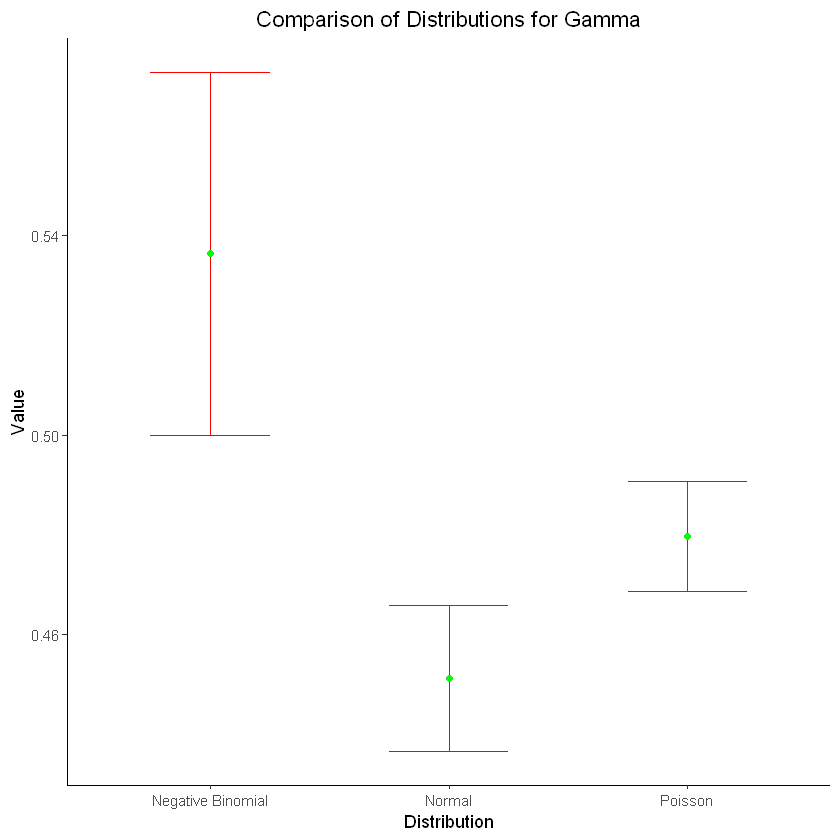

In [100]:
gamma_estimates <- data.frame(distribution = c('Normal', 'Poisson', 'Negative Binomial'),
                             value=c(normal_params['gamma'],poisson_params['gamma'], negativeBin_params['gamma']),
                             uncertainty = c(normal_err[2], poisson_err[2], negativeBin_err[2]));

ggplot(gamma_estimates, aes(x = distribution, y=value)) +
  geom_errorbar(aes(ymin=value-uncertainty, ymax=value+uncertainty), width=.5,
                 position=position_dodge(.9), color='red')+geom_point(color='green')+theme_classic()+labs(title="Comparison of Distributions for Gamma",
        x ="Distribution", y = "Value")+ theme(plot.title = element_text(hjust = 0.5))

## Initial Growth
Considering the dataset in log space and then restricting dataset to linear(ish) subset of logspace data. 

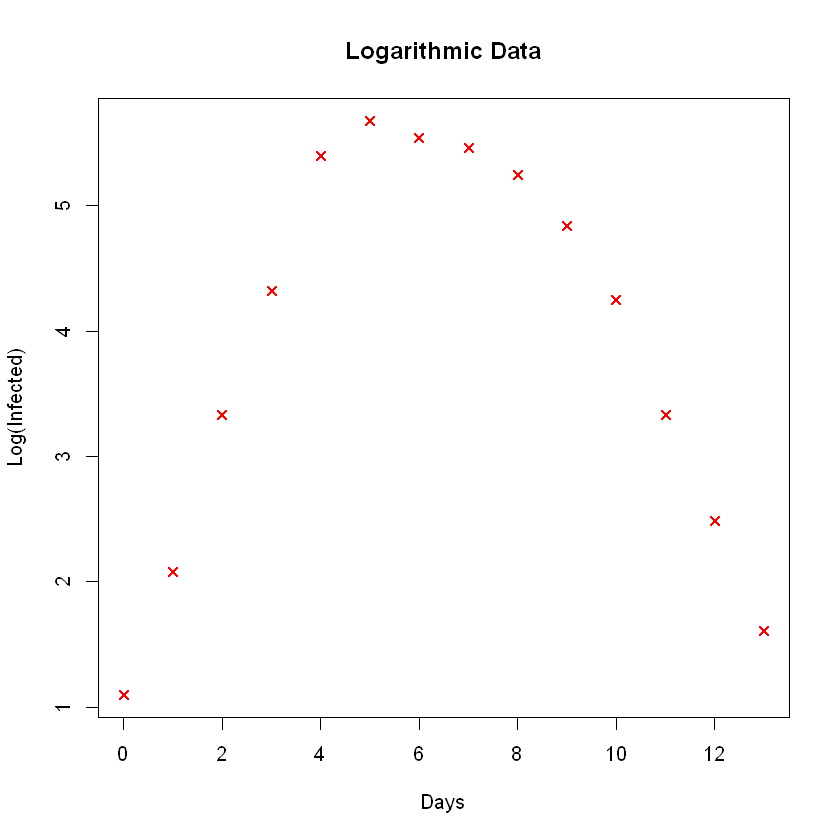

In [101]:
plot(df$days, log(df$cases), xlab='Days', ylab='Log(Infected)', main='Logarithmic Data', col='red', pch=4, lwd=1.6)

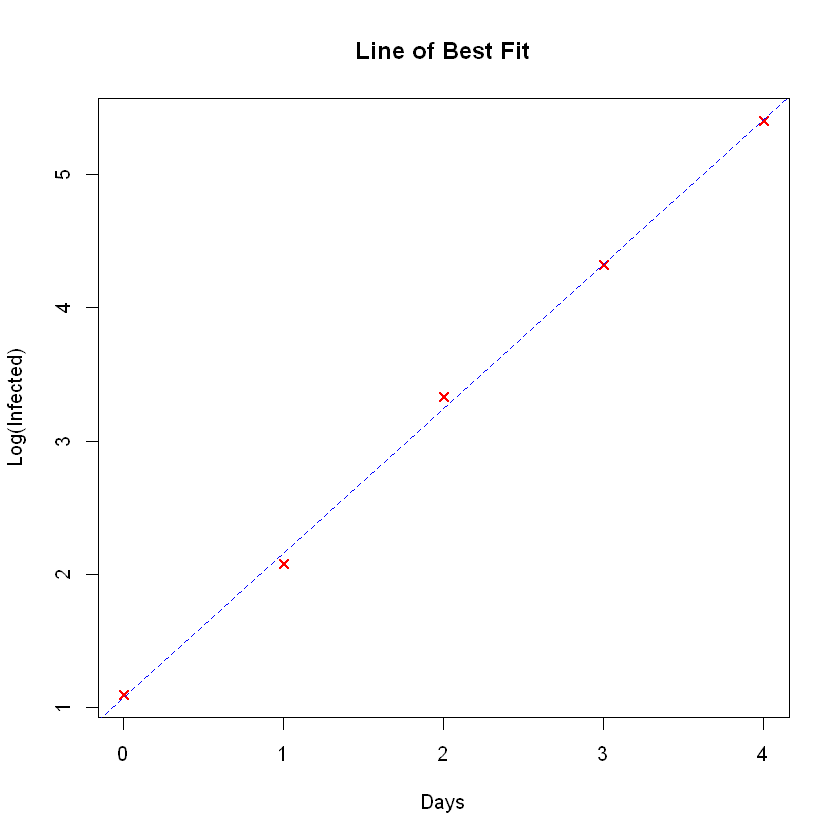

In [111]:
expgrowth_df <- head(df,5);
#create scatter plot of x vs. y
plot(expgrowth_df$days, log(expgrowth_df$cases), xlab='Days', ylab='Log(Infected)', main='Line of Best Fit', col='red', pch=4, lwd=1.6)

#add line of best fit to scatter plot
abline(lm(log(expgrowth_df$cases) ~ expgrowth_df$days), col='blue' , lty='dashed')

In [115]:
coefficients <- summary(lm(log(expgrowth_df$cases) ~ expgrowth_df$days))$coefficients;
coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.077752,0.05490936,19.62784,0.0002889412
expgrowth_df$days,1.083715,0.02241665,48.34418,0.0000194881


## Comparing Exponential Model with Model

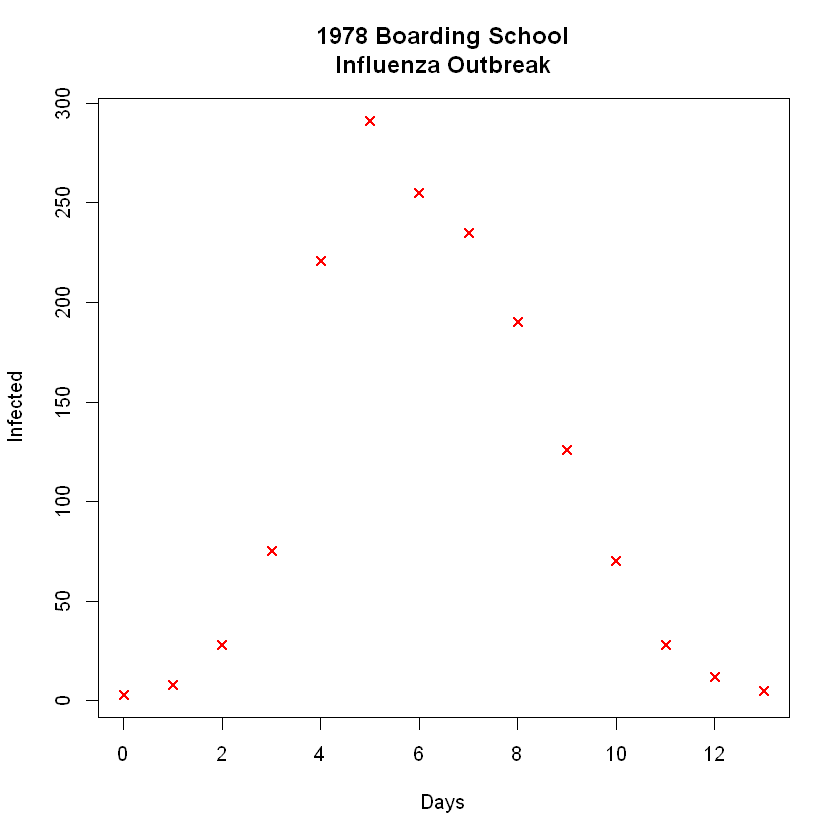

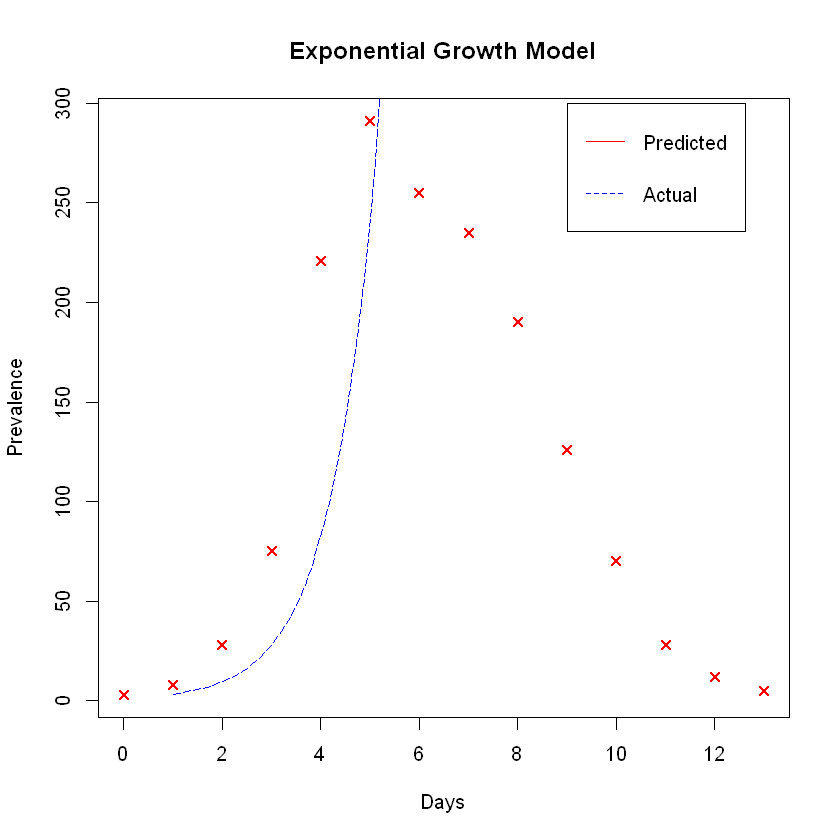

In [120]:
plot(df$days, df$cases, xlab='Days', ylab='Infected', main='1978 Boarding School
Influenza Outbreak', col='red', pch=4, lwd=1.6)
predicted <- coefficients[1]*exp(coefficients[2]*times);
compare_model(predicted, "Exponential Growth Model", times)

## MCMC